In [1]:
import os
import sys
import random
import json
import collections
import itertools

import pandas as pd
import numpy as np
import scipy        
import statsmodels


from tqdm import trange, tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns

import pickle
import torch
import torchtext
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import time
import torch.optim as optim
from torchtext.data import Field
from torchtext.data import Dataset, TabularDataset
from torchtext.data import Iterator

from annoy import AnnoyIndex

from MulticoreTSNE import MulticoreTSNE as TSNE

%matplotlib inline

pd.options.display.max_columns = 999

sns.set()

plt.rcParams["figure.figsize"] = (10,7)

In [2]:
os.getcwd()

'/home/boris/study/UT study/ACM Sigmod/sigmod/notebooks'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from sigmod_src.utils import read_json, pprint_json, path_from_spec_id, get_vector_for_spec_id
from sigmod_src.data.embedding import Embedder, LSTMEmbedder, get_fields

# Load data

In [5]:
LABELS_PATH = '../data/raw/sigmod_medium_labelled_dataset.csv'

In [6]:
labels_df = pd.read_csv(LABELS_PATH)

In [7]:
labels_df.shape

(46665, 3)

In [8]:
labels_df.head()

,left_spec_id,right_spec_id,label
0,www.garricks.com.au//31,www.ebay.com//53278,1
1,www.ebay.com//58782,www.ebay.com//24817,0
2,www.ebay.com//58782,www.ebay.com//43019,0
3,www.ebay.com//42055,www.ebay.com//54403,0
4,www.ebay.com//44280,buy.net//6145,0


In [9]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46665 entries, 0 to 46664
Data columns (total 3 columns):
left_spec_id     46665 non-null object
right_spec_id    46665 non-null object
label            46665 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


# Load specs df

In [10]:
specs_df = pd.read_csv('../data/processed/specs_preprocessed.csv')
# specs_df.index=  specs_df.spec_id
specs_df.shape

(29771, 5)

In [11]:
specs_df[specs_df.page_title.isnull()]

,spec_id,page_title,page_title_stem,brand,site


In [12]:
specs_df.head()

,spec_id,page_title,page_title_stem,brand,site
0,www.ebay.com//57656,canon powershot elph 110 hs 16 1 mp,canon powershot elph 110 hs 16 1 mp,canon,www.ebay.com
1,www.ebay.com//60583,canon rebel 2000 35 mm great condition case,canon rebel 2000 35 mm great condit case,canon,www.ebay.com
2,www.ebay.com//60440,canon eos rebel t3i 18 55mm,canon eo rebel t3i 18 55mm,canon,www.ebay.com
3,www.ebay.com//24139,ge c1033 10 1 mp 3x zoom 2,ge c1033 10 1 mp 3x zoom 2,ge,www.ebay.com
4,www.ebay.com//54903,vivitar clip shot 1 1 mp,vivitar clip shot 1 1 mp,vivitar,www.ebay.com


# Classes df

In [13]:
classes_df = pd.read_csv('../data/interim/classes.csv')
# classes_df.index = classes_df.spec_id
classes_df.head()

,spec_id,class_
0,buy.net//5641,0
1,www.ebay.com//58588,0
2,www.gosale.com//849,0
3,www.price-hunt.com//9794,0
4,buy.net//5698,1


## Add classes to specs

In [14]:
specs_df = specs_df.merge(classes_df, how='left')
specs_df.head()

,spec_id,page_title,page_title_stem,brand,site,class_
0,www.ebay.com//57656,canon powershot elph 110 hs 16 1 mp,canon powershot elph 110 hs 16 1 mp,canon,www.ebay.com,NaN
1,www.ebay.com//60583,canon rebel 2000 35 mm great condition case,canon rebel 2000 35 mm great condit case,canon,www.ebay.com,NaN
2,www.ebay.com//60440,canon eos rebel t3i 18 55mm,canon eo rebel t3i 18 55mm,canon,www.ebay.com,NaN
3,www.ebay.com//24139,ge c1033 10 1 mp 3x zoom 2,ge c1033 10 1 mp 3x zoom 2,ge,www.ebay.com,NaN
4,www.ebay.com//54903,vivitar clip shot 1 1 mp,vivitar clip shot 1 1 mp,vivitar,www.ebay.com,NaN


In [15]:
specs_df[specs_df.class_ == 0]

,spec_id,page_title,page_title_stem,brand,site,class_
1476,www.ebay.com//59612,excellent nikon d4 body 16 2 mp fx free,excel nikon d4 bodi 16 2 mp fx free,nikon,www.ebay.com,0.0
10648,www.ebay.com//58588,nikon d4 16 2 mp body,nikon d4 16 2 mp bodi,nikon,www.ebay.com,0.0
12740,www.ebay.com//54217,near mint nikon d4 body 16 2 mp fx,near mint nikon d4 bodi 16 2 mp fx,nikon,www.ebay.com,0.0
14506,www.price-hunt.com//9794,nikon d4 best india 2014,nikon d4 best india 2014,nikon,www.price-hunt.com,0.0
18853,buy.net//5641,nikon d4 body,nikon d4 bodi,nikon,buy.net,0.0
28521,www.gosale.com//849,nikon d4 cmos fx sale,nikon d4 cmos fx sale,nikon,www.gosale.com,0.0


In [16]:
labelled_specs_df = specs_df[~specs_df.class_.isnull()]

In [17]:
labelled_specs_df.to_csv('../data/interim/specs_df_labelled.csv', index=None)

# Triplet generator

In [18]:
labelled_specs_df['spec_idx'] = range(len(labelled_specs_df))
labelled_specs_df.head()

/home/boris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,spec_id,page_title,page_title_stem,brand,site,class_,spec_idx
46,www.ebay.com//41954,canon eos 20d 8 2 mp,canon eo 20d 8 2 mp,canon,www.ebay.com,6.0,0
120,www.ebay.com//48059,canon 20d 8 2 mp 28 80mm,canon 20d 8 2 mp 28 80mm,canon,www.ebay.com,6.0,1
146,www.ebay.com//47121,nikon d3200 24 2 mp kit,nikon d3200 24 2 mp kit,nikon,www.ebay.com,1.0,2
245,www.ebay.com//45559,nikon 1 j3 w vr 10 30mm,nikon 1 j3 w vr 10 30mm,nikon,www.ebay.com,7.0,3
256,www.ebay.com//58782,nikon d80 10 2 mp kit,nikon d80 10 2 mp kit,nikon,www.ebay.com,15.0,4


In [19]:
spec_lookup = labelled_specs_df.groupby(['class_'])['spec_idx'].agg(list).to_dict()
spec_lookup[0]

[16, 143, 171, 196, 275, 294]

In [20]:
class_lookup = labelled_specs_df[~labelled_specs_df.class_.isnull()].set_index('spec_idx').to_dict()['class_']
class_lookup[143]

0.0

In [21]:
def gen_triplet(anchor_id,
               class_lookup_table,
               id_lookup_table
               ):
    anchor_class = class_lookup_table[anchor_id]
    positive_id = random.choice(list(set(id_lookup_table[anchor_class]).difference(set([anchor_id]))))
    
    negative_class = random.choice(list(set(id_lookup_table.keys()).difference([anchor_class])))
    negative_id = random.choice(id_lookup_table[negative_class])
    return (anchor_id, positive_id, negative_id)

In [22]:
labelled_specs_df.iloc[list(gen_triplet(0, class_lookup, spec_lookup))]

,spec_id,page_title,page_title_stem,brand,site,class_,spec_idx
46,www.ebay.com//41954,canon eos 20d 8 2 mp,canon eo 20d 8 2 mp,canon,www.ebay.com,6.0,0
29034,cammarkt.com//413,cammarkt canon eos 20d,cammarkt canon eo 20d,canon,cammarkt.com,6.0,298
29049,cammarkt.com//203,cammarkt sony a55 zoom lens,cammarkt soni a55 zoom len,sony,cammarkt.com,5.0,299


# Triplet loss model

In [23]:
text_field = get_fields()

In [24]:
%%time
datafields = [("spec_id", None),
              ("page_title", None),
                 ("page_title_stem", text_field),
                  ("brand", None),
                  ("site", None),
             ('class_', None)]

full_dataset = TabularDataset.splits(
        path="../data/processed/", # the root directory where the data lies
        train='specs_preprocessed.csv',
        format='csv',
        skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
        fields=datafields)

train_dataset = TabularDataset.splits(
        path="../data/interim/", # the root directory where the data lies
        train='specs_df_labelled.csv',
        format='csv',
        skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
        fields=datafields)

full_dataset = full_dataset[0]
train_dataset = train_dataset[0]

CPU times: user 319 ms, sys: 7.97 ms, total: 327 ms
Wall time: 326 ms


In [25]:
specs_df.head(1)

,spec_id,page_title,page_title_stem,brand,site,class_
0,www.ebay.com//57656,canon powershot elph 110 hs 16 1 mp,canon powershot elph 110 hs 16 1 mp,canon,www.ebay.com,NaN


In [26]:
train_dataset.examples[0].__dict__

{'page_title_stem': ['canon', 'eo', '20d', '8', '2', 'mp']}

In [27]:
full_dataset.examples[0].__dict__

{'page_title_stem': ['canon',
  'powershot',
  'elph',
  '110',
  'hs',
  '16',
  '1',
  'mp']}

In [28]:
train_dataset[gen_triplet(0, class_lookup, spec_lookup)[0]].__dict__, train_dataset[gen_triplet(0, class_lookup, spec_lookup)[2]].__dict__

({'page_title_stem': ['canon', 'eo', '20d', '8', '2', 'mp']},
 {'page_title_stem': ['nikon',
   'd7000',
   '16',
   '2',
   'megapixel',
   'dx',
   'bodi',
   'great']})

In [29]:
%%time
text_field.build_vocab(full_dataset)

CPU times: user 212 ms, sys: 3.67 ms, total: 216 ms
Wall time: 221 ms


## Model params

In [30]:
emb_dim = 300
hidden_dim = 200
num_linear = 2
num_lstm = 1
model = LSTMEmbedder(text_field,
                     hidden_dim, emb_dim=emb_dim, num_linear=num_linear, num_lstm=num_lstm)

model

/home/boris/anaconda3/lib/python3.6/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


LSTMEmbedder(
  (embedding): Embedding(7601, 300)
  (encoder): LSTM(300, 200, dropout=0.1)
  (linear_layers): ModuleList(
    (0): Linear(in_features=200, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=200, bias=True)
  )
)

In [31]:
model.text_field.vocab.freqs.most_common(10)

[('mp', 8110),
 ('canon', 5561),
 ('nikon', 4816),
 ('1', 3283),
 ('soni', 3246),
 ('case', 2893),
 ('0', 2615),
 ('eo', 2444),
 ('powershot', 2393),
 ('2', 2317)]

In [32]:
train_dataset[0].page_title_stem

['canon', 'eo', '20d', '8', '2', 'mp']

In [33]:
def triplet_iterator(model, dataset):
    shuffled_idx = list(range(len(dataset)))
    np.random.shuffle(shuffled_idx)
    
    for i in shuffled_idx:
        _, pos_idx, neg_idx = gen_triplet(i, class_lookup, spec_lookup)
        
        triplet = [train_dataset[i].page_title_stem, 
                   train_dataset[pos_idx].page_title_stem,
                   train_dataset[neg_idx].page_title_stem]
        triplet = model.text_field.pad(triplet)
        triplet = model.text_field.numericalize(triplet[:3])
        yield triplet
        
next(iter(triplet_iterator(model, train_dataset)))

tensor([[   6,    6,    3],
        [  61,  669,   10],
        [ 505,   51,  915],
        [2682,   27,  236],
        [6895,   71,  450],
        [1785,    1, 1414],
        [   1,    1,  249],
        [   1,    1,   83],
        [   1,    1,   42]])

In [34]:
model.infer(['canon eos 20d 8 2 mp'])

tensor([[-0.0712,  0.0480, -0.0103, -0.0397, -0.0182,  0.0044, -0.0304, -0.0393,
          0.0471, -0.0270,  0.0641,  0.1376, -0.0653, -0.0281,  0.1182, -0.0041,
          0.0241,  0.0423,  0.0813,  0.0697, -0.1015, -0.0785,  0.0504, -0.0365,
         -0.0378,  0.0292,  0.0200,  0.0391, -0.0696,  0.0102, -0.0106,  0.0920,
         -0.0727,  0.0197, -0.0208,  0.0036, -0.0567,  0.0036, -0.0528,  0.0409,
         -0.0006, -0.0199,  0.0579,  0.0447, -0.0532,  0.0319, -0.0443,  0.0803,
          0.0108, -0.0947, -0.0323,  0.1101,  0.0657, -0.0271, -0.0413,  0.0949,
         -0.0408,  0.1179, -0.0476,  0.0668, -0.0693,  0.0671, -0.0361, -0.0507,
         -0.0432,  0.0708,  0.0586,  0.0462, -0.0435, -0.0326,  0.0154,  0.0455,
          0.0798, -0.0106,  0.0520,  0.1497, -0.0957, -0.0883, -0.0538, -0.0182,
          0.1131,  0.0271, -0.0467, -0.0038, -0.0522, -0.1196, -0.0210, -0.0196,
          0.0008,  0.0324,  0.0489,  0.0715,  0.0295,  0.0111,  0.0383,  0.0006,
         -0.0126,  0.0757,  

In [35]:
def triplet_loss(anchor, pos, neg, margin=0.9):
    """
    Consine similarity for between anchor and positive should be >= 0.8
    
    Cosine similarity for negative should be < 0.8
    """
    
    pos_dist = F.cosine_similarity(anchor, pos, dim=0)
    neg_dist = F.cosine_similarity(anchor, neg, dim=0)
    
    loss_pos = torch.clamp(margin-pos_dist, min=0)
    loss_neg = torch.clamp(neg_dist-margin, min=0)
    
    return loss_pos + loss_neg

In [36]:
loss_history = []

In [50]:
opt = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10)
epochs = 20

In [51]:
%%time
for epoch in tqdm(range(1, epochs + 1)):
    model.train()
    
    running_loss = 0
    count_triplets = 0
    
    for triplet in tqdm(iter(triplet_iterator(model, train_dataset))):
        opt.zero_grad()
        
        embeddings = model(triplet)
        loss = triplet_loss(embeddings[0], embeddings[1], embeddings[2])
        loss.backward()
        opt.step()
        
        
        running_loss += loss.data
        count_triplets +=1 
    scheduler.step()
    epoch_loss = running_loss / count_triplets
    loss_history.append(epoch_loss)
    
    print('Epoch: {}, Training Loss: {:.4f}'.format(epoch, epoch_loss))
model.eval()

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 1, Training Loss: 0.0069


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 2, Training Loss: 0.0060


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 3, Training Loss: 0.0061


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 4, Training Loss: 0.0068


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 5, Training Loss: 0.0057


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 6, Training Loss: 0.0057


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 7, Training Loss: 0.0051


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 8, Training Loss: 0.0047


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 9, Training Loss: 0.0049


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 10, Training Loss: 0.0042


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 11, Training Loss: 0.0034


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 12, Training Loss: 0.0024


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 13, Training Loss: 0.0025


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 14, Training Loss: 0.0020


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 15, Training Loss: 0.0016


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 16, Training Loss: 0.0022


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 17, Training Loss: 0.0031


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 18, Training Loss: 0.0014


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 19, Training Loss: 0.0017


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Epoch: 20, Training Loss: 0.0016
CPU times: user 7min 22s, sys: 2min 42s, total: 10min 5s
Wall time: 3min 28s


In [52]:
model.eval()

LSTMEmbedder(
  (embedding): Embedding(7601, 300)
  (encoder): LSTM(300, 200, dropout=0.1)
  (linear_layers): ModuleList(
    (0): Linear(in_features=200, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=200, bias=True)
  )
)

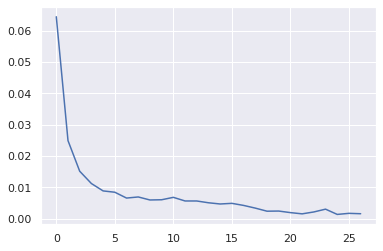

In [53]:
plt.figure()
plt.plot(loss_history, label='loss')
plt.show()

# Produce train embeddings and TSNE

In [54]:
embeddings = []
for ex in tqdm(train_dataset):
    emb = np.array(model(model.text_field.numericalize([ex.page_title_stem]))[0].data)
    embeddings.append(emb)
embeddings = np.array(embeddings)

HBox(children=(IntProgress(value=0, max=306), HTML(value='')))

In [55]:
tsne = TSNE(
    n_components=2,
    metric='cosine',
    n_jobs=3,
    verbose=True,
)

In [56]:
emb_ld = tsne.fit_transform(embeddings)

In [57]:
emb_ld.shape

(306, 2)

In [58]:
labelled_spec_classes = labelled_specs_df.class_
labelled_spec_classes = labelled_spec_classes.reset_index()
labelled_spec_classes.shape

(306, 2)

In [59]:
labelled_spec_classes.head()

,index,class_
0,46,6.0
1,120,6.0
2,146,1.0
3,245,7.0
4,256,15.0


In [60]:
emb_tdf = pd.DataFrame(emb_ld)
emb_tdf = pd.concat([emb_tdf, labelled_spec_classes], axis=1, ignore_index=True)
emb_tdf.columns = ['x', 'y', 'original_index', 'class_']
emb_tdf.head()

,x,y,original_index,class_
0,0.624552,-7.604122,46,6.0
1,-1.207106,-7.499354,120,6.0
2,3.699268,23.099670,146,1.0
3,9.096563,1.586126,245,7.0
4,9.029452,4.315490,256,15.0


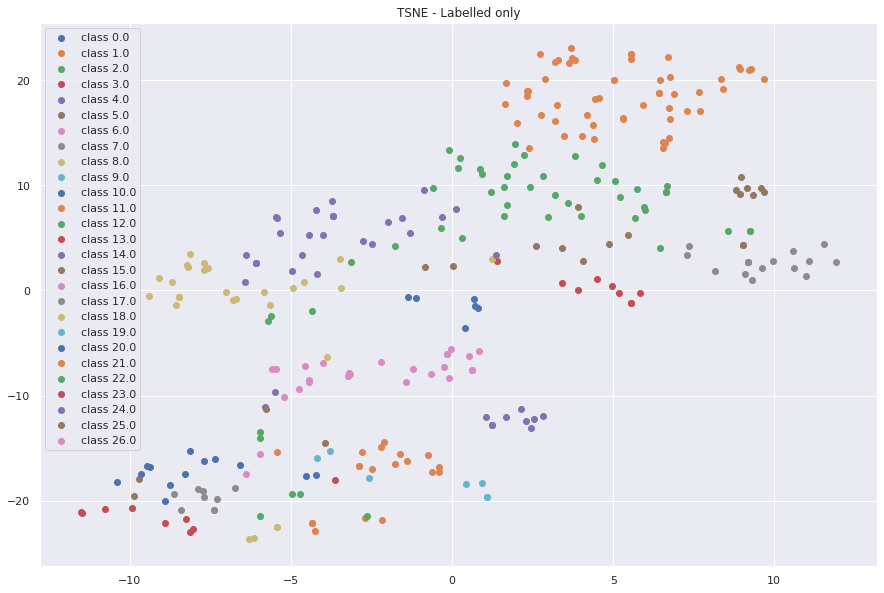

In [61]:
plt.figure(figsize=(15, 10))
plt.title('TSNE - Labelled only')
for class_ in emb_tdf['class_'].sort_values().unique():
    class_ld_df = emb_tdf[emb_tdf.class_==class_]
    plt.scatter(class_ld_df.iloc[:, 0], class_ld_df.iloc[:, 1], label=f'class {class_}')

plt.legend()
plt.show()

# Produce whole dataset embeddings

In [62]:
embeddings = []
for ex in tqdm(full_dataset):
    emb = np.array(model(model.text_field.numericalize([ex.page_title_stem]))[0].data)
    embeddings.append(emb)
embeddings = np.array(embeddings)

HBox(children=(IntProgress(value=0, max=29771), HTML(value='')))

In [63]:
emb = Embedder(model, specs_df.spec_id.values, specs_df.page_title_stem.values)

In [64]:
emb.fit(embeddings)

In [65]:
emb.lookup_texts('canon eo 20d')

array(['cammarkt canon eo 20d', 'cammarkt canon eo 20d',
       'cammarkt canon eo 20d', 'canon 20d', 'hd sdi case canon eo car',
       'canon t3i 18 55mm len 600d canon eo',
       '40m 130ft waterproof dive underwat hous case canon eo',
       'gopro case bag accessori bag extrem',
       'canon eo d30 3 2 mp w canon', 'eva waterproof case canon eo'],
      dtype=object)

In [66]:
emb.save('../models/embedder')